# Compare: Ridge, PCA+Ridge, LDA+Ridge, DCT+Ridge
#“We are trying to predict the critical temperature of superconductors using different feature transformation + regression techniques, and compare their performance.”

This notebook runs four pipelines on the superconductivity dataset (target = `critical_temp`):
1. Ridge on full features
2. PCA → Ridge
3. LDA (quantile bins) → Ridge
4. DCT (keep first-k) → Ridge

It reports train/test RMSE, MAE, R² and saves a CSV with the metrics.


“Here we import all the required libraries for machine learning, feature transformation, and model evaluation.”



In [1]:

# Imports and global settings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Notebook settings
RANDOM_STATE = 42
TEST_SIZE = 0.20

# Method-specific params
PCA_K = 50
LDA_BINS = 50
DCT_K = 50

# Files / paths
# CSV_REL = os.path.join("data", "superconductivty_data_set.csv")
CSV_REL = "superconductivty_data_set.csv"
OUT_DIR = "data"
METRICS_CSV = os.path.join(OUT_DIR, "metrics_comparison.csv")

# Utility
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)


In [2]:
# Load CSV (adjust path if needed)
csv_path = os.path.join(os.getcwd(), CSV_REL)
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}. Place 'superconductivty_data_set.csv' in data/")

df = pd.read_csv(csv_path)
# strip whitespace from column names
df.rename(columns={c: c.strip() for c in df.columns}, inplace=True)

TARGET = "critical_temp"
if TARGET not in df.columns:
    raise KeyError(f"Target '{TARGET}' not found. Columns: {list(df.columns)[:20]}")

print("Loaded dataset:", df.shape)
df.head()


FileNotFoundError: CSV not found at d:\DTU-Material\ML\Grp-Project\superconductivty_data_set.csv. Place 'superconductivty_data_set.csv' in data/

In [ ]:
# Split first to avoid leakage (we'll fit preprocessors on training data only)
X_df = df.drop(columns=[TARGET]).copy()
y = df[TARGET].values

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Train / Test sizes:", X_train_df.shape[0], X_test_df.shape[0])
print("Target stats (train):", pd.Series(y_train).describe().to_dict())


Train / Test sizes: 17010 4253
Target stats (train): {'count': 17010.0, 'mean': 34.53330097442681, 'std': 34.33467260601755, 'min': 0.00021, '25%': 5.4, '50%': 20.0, '75%': 63.0, 'max': 185.0}


In [ ]:
# Fit imputer + scaler on training set
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_df)
X_train_scaled = scaler.fit_transform(X_train_imp)

X_test_imp = imputer.transform(X_test_df)
X_test_scaled = scaler.transform(X_test_imp)

print("Scaled feature shape (train):", X_train_scaled.shape)


Scaled feature shape (train): (17010, 81)


In [ ]:
def train_and_eval_ridge(X_tr, X_te, y_tr, y_te):
    t0 = time.perf_counter()
    model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    model.fit(X_tr, y_tr)
    t_train = time.perf_counter() - t0

    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    return {
        "train_time_sec": t_train,
        # "train_rmse": float(rmse(y_tr, pred_tr)),
        "test_rmse": float(rmse(y_te, pred_te)),
        # "train_mae": float(mean_absolute_error(y_tr, pred_tr)),
        "test_mae": float(mean_absolute_error(y_te, pred_te)),
        # "train_r2": float(r2_score(y_tr, pred_tr)),
        "test_r2": float(r2_score(y_te, pred_te))
    }


1) Ridge on full features

In [ ]:
print("Running: Ridge on FULL features")
res_full = train_and_eval_ridge(X_train_scaled, X_test_scaled, y_train, y_test)
res_full.update({"method": "ridge_full", "notes": "no_reduction", "reduced_shape": X_train_scaled.shape})
res_full


Running: Ridge on FULL features


{'train_time_sec': 0.9870346449999943,
 'test_rmse': 17.404416816403078,
 'test_mae': 13.218694681219354,
 'test_r2': 0.736844002793025,
 'method': 'ridge_full',
 'notes': 'no_reduction',
 'reduced_shape': (17010, 81)}

2) PCA → Ridge

In [ ]:
print("Running: PCA -> Ridge")
k_pca = min(PCA_K, X_train_scaled.shape[1])
pca = PCA(n_components=k_pca, random_state=RANDOM_STATE)
Xtr_pca = pca.fit_transform(X_train_scaled)
Xte_pca = pca.transform(X_test_scaled)

res_pca = train_and_eval_ridge(Xtr_pca, Xte_pca, y_train, y_test)
res_pca.update({
    "method": "pca_ridge",
    "notes": f"pca_k={k_pca}",
    "reduced_shape": (Xtr_pca.shape[0], Xtr_pca.shape[1]),
    "explained_variance": float(pca.explained_variance_ratio_.sum())
})
res_pca


Running: PCA -> Ridge


{'train_time_sec': 0.01975084700006846,
 'test_rmse': 18.32412032743347,
 'test_mae': 14.102952512418499,
 'test_r2': 0.7082972049188963,
 'method': 'pca_ridge',
 'notes': 'pca_k=50',
 'reduced_shape': (17010, 50),
 'explained_variance': 0.9984252730008261}

3) LDA → Ridge (quantile bins using training labels)

In [ ]:
print("Running: LDA -> Ridge")
if LDA_BINS < 2:
    raise ValueError("LDA_BINS must be >= 2")

# create quantile bins using training y (to avoid leakage)
quantiles = np.linspace(0, 1, LDA_BINS + 1)
bins = np.quantile(y_train, quantiles)
bin_edges = bins[1:-1]  # exclude min/max
ytr_b = np.digitize(y_train, bin_edges, right=True)
yte_b = np.digitize(y_test, bin_edges, right=True)

n_classes = len(np.unique(ytr_b))
if n_classes < 2:
    raise ValueError("Less than 2 classes after binning")

n_lda_components = n_classes - 1
lda = LDA(n_components=n_lda_components)
Xtr_lda = lda.fit_transform(X_train_scaled, ytr_b)
Xte_lda = lda.transform(X_test_scaled)

res_lda = train_and_eval_ridge(Xtr_lda, Xte_lda, y_train, y_test)
res_lda.update({
    "method": "lda_ridge",
    "notes": f"lda_bins={LDA_BINS}",
    "reduced_shape": (Xtr_lda.shape[0], Xtr_lda.shape[1]),
    "n_classes": int(n_classes)
})
res_lda


Running: LDA -> Ridge


{'train_time_sec': 0.030811676999974225,
 'test_rmse': 17.378834064464712,
 'test_mae': 13.211198399209055,
 'test_r2': 0.7376170602069165,
 'method': 'lda_ridge',
 'notes': 'lda_bins=50',
 'reduced_shape': (17010, 49),
 'n_classes': 50}

4) DCT → Ridge

In [ ]:
print("Running: DCT -> Ridge")
def apply_dct_rows(X):
    return dct(X, type=2, norm="ortho", axis=1)

Xtr_dct = apply_dct_rows(X_train_scaled)
Xte_dct = apply_dct_rows(X_test_scaled)
k_dct = min(DCT_K, Xtr_dct.shape[1])

Xtr_dct_red = Xtr_dct[:, :k_dct]
Xte_dct_red = Xte_dct[:, :k_dct]

# compute approx energy retained (train)
energy_all = np.sum(Xtr_dct**2, axis=1)
energy_kept = np.sum(Xtr_dct_red**2, axis=1)
energy_ratio_mean = float(np.mean(np.where(energy_all>0, energy_kept/energy_all, 0.0)))

res_dct = train_and_eval_ridge(Xtr_dct_red, Xte_dct_red, y_train, y_test)
res_dct.update({
    "method": "dct_ridge",
    "notes": f"dct_k={k_dct}",
    "reduced_shape": (Xtr_dct_red.shape[0], Xtr_dct_red.shape[1]),
    "energy_ratio_train_mean": energy_ratio_mean
})
res_dct


Running: DCT -> Ridge


{'train_time_sec': 0.07938074000003326,
 'test_rmse': 18.146593512507653,
 'test_mae': 13.924392346838731,
 'test_r2': 0.7139219461296231,
 'method': 'dct_ridge',
 'notes': 'dct_k=50',
 'reduced_shape': (17010, 50),
 'energy_ratio_train_mean': 0.7982302105774144}



---



In [ ]:
results = [res_full, res_pca, res_lda, res_dct]
df_res = pd.DataFrame(results)

# reorder columns for readability
cols_order = ["method", "notes", "reduced_shape", "train_time_sec",
              "train_rmse", "test_rmse", "train_mae", "test_mae",
              "train_r2", "test_r2"]
cols_order = ["method", "notes", "reduced_shape", "train_time_sec",
              "test_rmse", "test_mae", "test_r2"]
for c in df_res.columns:
    if c not in cols_order:
        cols_order.append(c)
df_res = df_res[cols_order]

# save and show
os.makedirs(OUT_DIR, exist_ok=True)
df_res.to_csv(METRICS_CSV, index=False)
print("Saved metrics to:", os.path.abspath(METRICS_CSV))
df_res


Saved metrics to: /content/data/metrics_comparison.csv


,method,notes,reduced_shape,train_time_sec,test_rmse,test_mae,test_r2,explained_variance,n_classes,energy_ratio_train_mean
0,ridge_full,no_reduction,"(17010, 81)",0.987035,17.404417,13.218695,0.736844,NaN,NaN,NaN
1,pca_ridge,pca_k=50,"(17010, 50)",0.019751,18.324120,14.102953,0.708297,0.998425,NaN,NaN
2,lda_ridge,lda_bins=50,"(17010, 49)",0.030812,17.378834,13.211198,0.737617,NaN,50.0,NaN
3,dct_ridge,dct_k=50,"(17010, 50)",0.079381,18.146594,13.924392,0.713922,NaN,NaN,0.79823


In [ ]:
model_res = [res_full, res_pca, res_lda, res_dct]
model_names = ['Reg', 'PCA + Reg', 'LDA + Reg', 'DCT + Reg']
RMSE_res = []
MAE_res = []
Features_res = []
Train_Time_res = []
R_s_res = []

for model in model_res:
  RMSE_res.append(model["test_rmse"])
  MAE_res.append(model["test_mae"])
  Features_res.append(model["reduced_shape"][1])
  Train_Time_res.append(model["train_time_sec"])
  R_s_res.append(model["test_r2"]*100)

# RMSE_res
# MAE_res
# Features_res
# Train_Time_res
# R_s_res

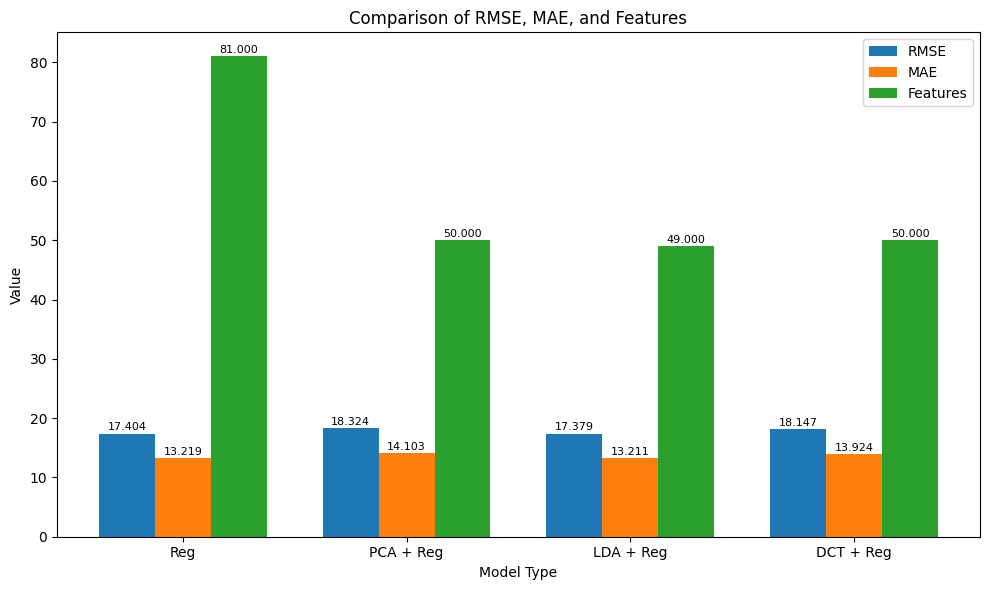

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define data
data = {
    'Model': ['Reg', 'PCA + Reg', 'LDA + Reg', 'DCT + Reg'],
    'RMSE': RMSE_res,
    'MAE': MAE_res,
    'Features': Features_res,
    'Train Time': Train_Time_res,
    'R²': R_s_res
}

# Create DataFrame
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
x = range(len(df))

# Plot bars
rmse_bars = ax.bar([i - bar_width for i in x], df['RMSE'], width=bar_width, label='RMSE', color='#1f77b4')
mae_bars = ax.bar(x, df['MAE'], width=bar_width, label='MAE', color='#ff7f0e')
feat_bars = ax.bar([i + bar_width for i in x], df['Features'], width=bar_width, label='Features', color='#2ca02c')

# Add text labels above bars
for bars in [rmse_bars, mae_bars, feat_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_xlabel('Model Type')
ax.set_ylabel('Value')
ax.set_title('Comparison of RMSE, MAE, and Features')
ax.set_xticks(list(x))
ax.set_xticklabels(df['Model'])
ax.legend()
plt.tight_layout()
plt.show()

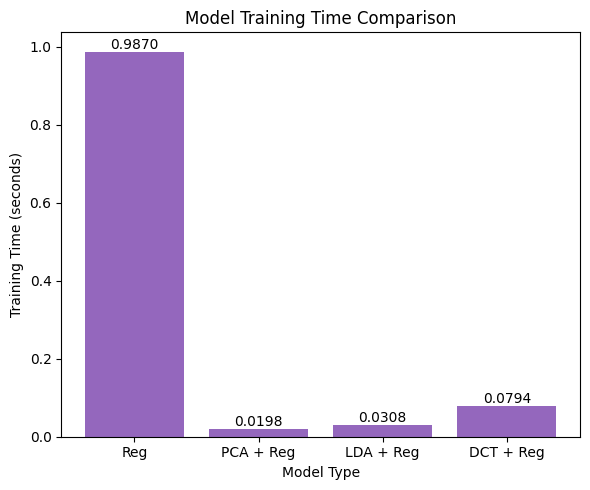

In [ ]:
plt.figure(figsize=(6, 5))
plt.bar(df['Model'], df['Train Time'], color='#9467bd')
plt.title('Model Training Time Comparison')
plt.xlabel('Model Type')
plt.ylabel('Training Time (seconds)')
for i, v in enumerate(df['Train Time']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

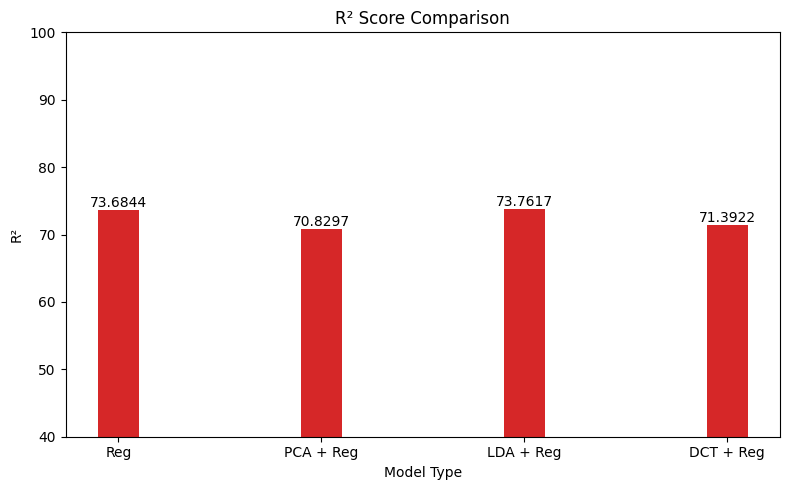

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(df['Model'], df['R²'], width=bar_width, color='#d62728')
plt.title('R² Score Comparison')
plt.xlabel('Model Type')
plt.ylabel('R²')
bar_width = 0.2
for i, v in enumerate(df['R²']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.ylim(40, 100)
# plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()